In [2]:
#import statements
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
#week 5 homework
from tensorflow.keras import layers, models
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from keras.applications.densenet import preprocess_input
from keras.applications.densenet import decode_predictions
from keras.applications.densenet import DenseNet121
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from tensorflow.keras.regularizers import l2

#googlenet
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

In [17]:
dir_name = '../input/archdataset/Capstone_Architectural_Styles_dataset/'

# Define parameters for loading the dataset
batch_size = 128
img_height = 224
img_width = 224
testing_split = 0.2  # 20% validation split
l2_reg = 0.0001

# Load dataset from directory and split into training and validation sets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=dir_name,
    labels='inferred',  # Use subdirectory names as labels
    label_mode='int',   # Labels are returned as integers
    validation_split=testing_split,
    subset='training',  # Use training subset
    seed=123,           # Set seed for reproducibility
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True   # Shuffle the training data
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=dir_name,
    labels='inferred',
    label_mode='int',
    validation_split=testing_split,
    subset='validation',  # Use testing subset
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True   # Shuffle the validation data
)

# Function to shrink the dataset if needed
def reduce_dataset_size(dataset, desired_size, batch_size):
    dataset = dataset.shuffle(buffer_size=10000, seed=123)
    return dataset.take(desired_size // batch_size)

# train_ds = reduce_dataset_size(train_ds, 900, batch_size)
# test_ds = reduce_dataset_size(test_ds, 100, batch_size)

# Print class names
class_names = train_ds.class_names
print("Class names:", class_names)

Found 12065 files belonging to 9 classes.
Using 9652 files for training.
Found 12065 files belonging to 9 classes.
Using 2413 files for validation.
Class names: ['21st_Century', 'Baroque', 'Classical', 'Early_Christian_Medieval', 'Eclecticism', 'Modernism', 'Neoclassicism', 'Renaissance_and_Colonialism', 'Revivalism']


In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Define the path to the uploaded GoogleNet checkpoint file
weights_path = '../input/googlenet/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Print class names
class_names = train_ds.class_names
num_classes = len(class_names)
print("Class names:", class_names)

# Load pre-trained InceptionV3 model with custom top layers
base_model = tf.keras.applications.InceptionV3(weights=None, include_top=False, input_shape=(img_height, img_width, 3))
base_model.load_weights(weights_path)  # Load weights from the uploaded file

# Add new top layers for our dataset
x = GlobalAveragePooling2D()(base_model.output)
# x = Dense(2048, activation='relu', kernel_regularizer=l2(l2_reg))(x)
# x = Dense(1024, activation='relu', kernel_regularizer=l2(l2_reg))(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(l2_reg))(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(l2_reg))(x)
# x = Dense(64, activation='relu', kernel_regularizer=l2(l2_reg))(x)
predictions = Dense(num_classes, activation='softmax', kernel_regularizer=l2(l2_reg))(x)

# Combine base model and new top layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers (optional)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

# Train the model
epochs = 10
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs
)


Class names: ['21st_Century', 'Baroque', 'Classical', 'Early_Christian_Medieval', 'Eclecticism', 'Modernism', 'Neoclassicism', 'Renaissance_and_Colonialism', 'Revivalism']


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_470 (Conv2D) │ (None, 111, 111,  │        864 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d_470[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_470      │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_471 (Conv2D) │ (None, 109, 109,  │      9,216 │ activation_470[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_471[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_471      │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_472 (Conv2D) │ (None, 109, 109,  │     18,432 │ activation_471[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_472[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_472      │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 54, 54,    │          0 │ activation_472[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_473 (Conv2D) │ (None, 54, 54,    │      5,120 │ max_pooling2d_20… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_473[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_473      │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_474 (Conv2D) │ (None, 52, 52,    │    138,240 │ activation_473[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_474[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_474      │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 23,017,257 (87.80 MB)

 Trainable params: 1,214,473 (4.63 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Epoch 1/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.1436 - loss: 10.6112

W0000 00:00:1720093693.121288      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/76 ━━━━━━━━━━━━━━━━━━━━ 89s 773ms/step - accuracy: 0.1439 - loss: 10.5426 - val_accuracy: 0.1956 - val_loss: 2.4771
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 30s 390ms/step - accuracy: 0.2245 - loss: 2.3505 - val_accuracy: 0.2138 - val_loss: 2.3128
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 30s 394ms/step - accuracy: 0.2553 - loss: 2.1653 - val_accuracy: 0.2590 - val_loss: 2.1450
Epoch 4/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 30s 398ms/step - accuracy: 0.2797 - loss: 2.0901 - val_accuracy: 0.2731 - val_loss: 2.1332
Epoch 5/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 30s 387ms/step - accuracy: 0.2991 - loss: 2.0326 - val_accuracy: 0.2719 - val_loss: 2.0958
Epoch 6/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 29s 377ms/step - accuracy: 0.3071 - loss: 1.9891 - val_accuracy: 0.3038 - val_loss: 2.0903
Epoch 7/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 28s 369ms/step - accuracy: 0.3341 - loss: 1.9429 - val_accuracy: 0.2884 - val_loss: 2.0563
Epoch 8/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.3172 - loss: 1.9384 - val_accuracy: 0.28

In [19]:
results = model.evaluate(test_ds)
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")
# print(f"Test Top-3 Accuracy: {results[2]}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 297ms/step - accuracy: 0.2876 - loss: 2.1706
Test Loss: 2.124302864074707
Test Accuracy: 0.2967260777950287


19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 590ms/step


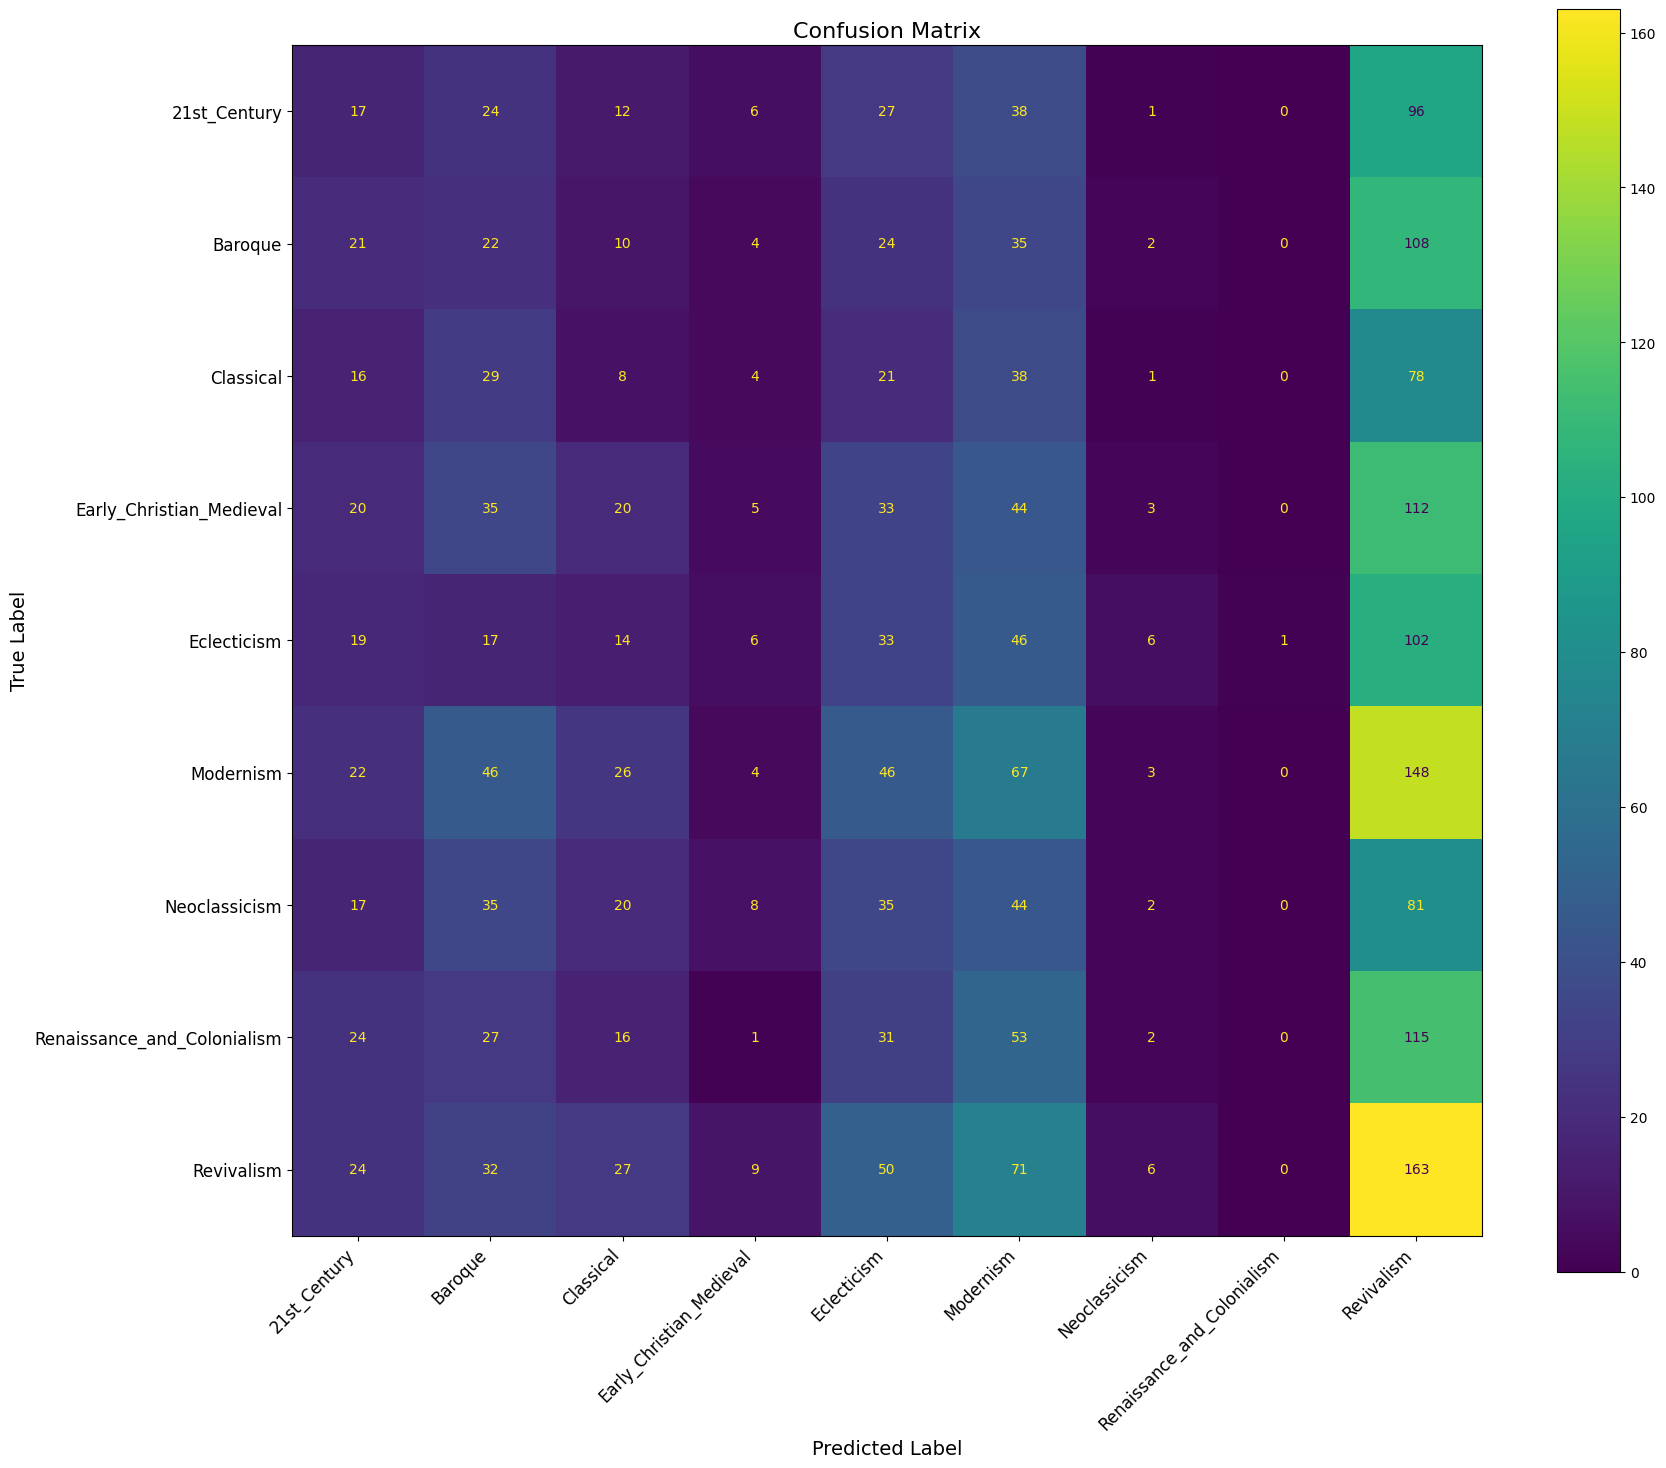

In [20]:
# Get true labels and predicted labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = np.argmax(model.predict(test_ds), axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot the confusion matrix with a larger figure size and rotated x-axis labels
fig, ax = plt.subplots(figsize=(18, 15))  # Adjust the size as needed
disp.plot(include_values=True, cmap='viridis', ax=ax, xticks_rotation=45)

# Customize the plot for better visibility if needed
plt.xticks(fontsize=12, ha='right')  # 'ha' parameter aligns the labels to the right
plt.yticks(fontsize=12)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)

plt.tight_layout()  # Ensures labels do not overlap

plt.show()

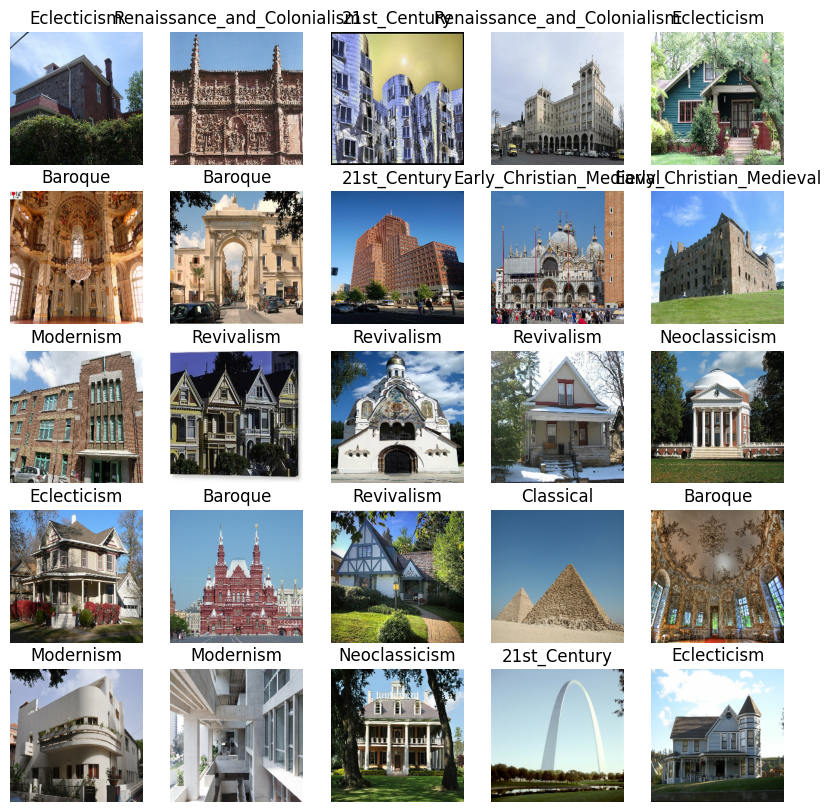

In [13]:
# Function to display images with labels
def display_images(dataset, class_names, num_images):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
    plt.show()

# Display 25 images from the training dataset
display_images(train_ds, class_names, 25)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


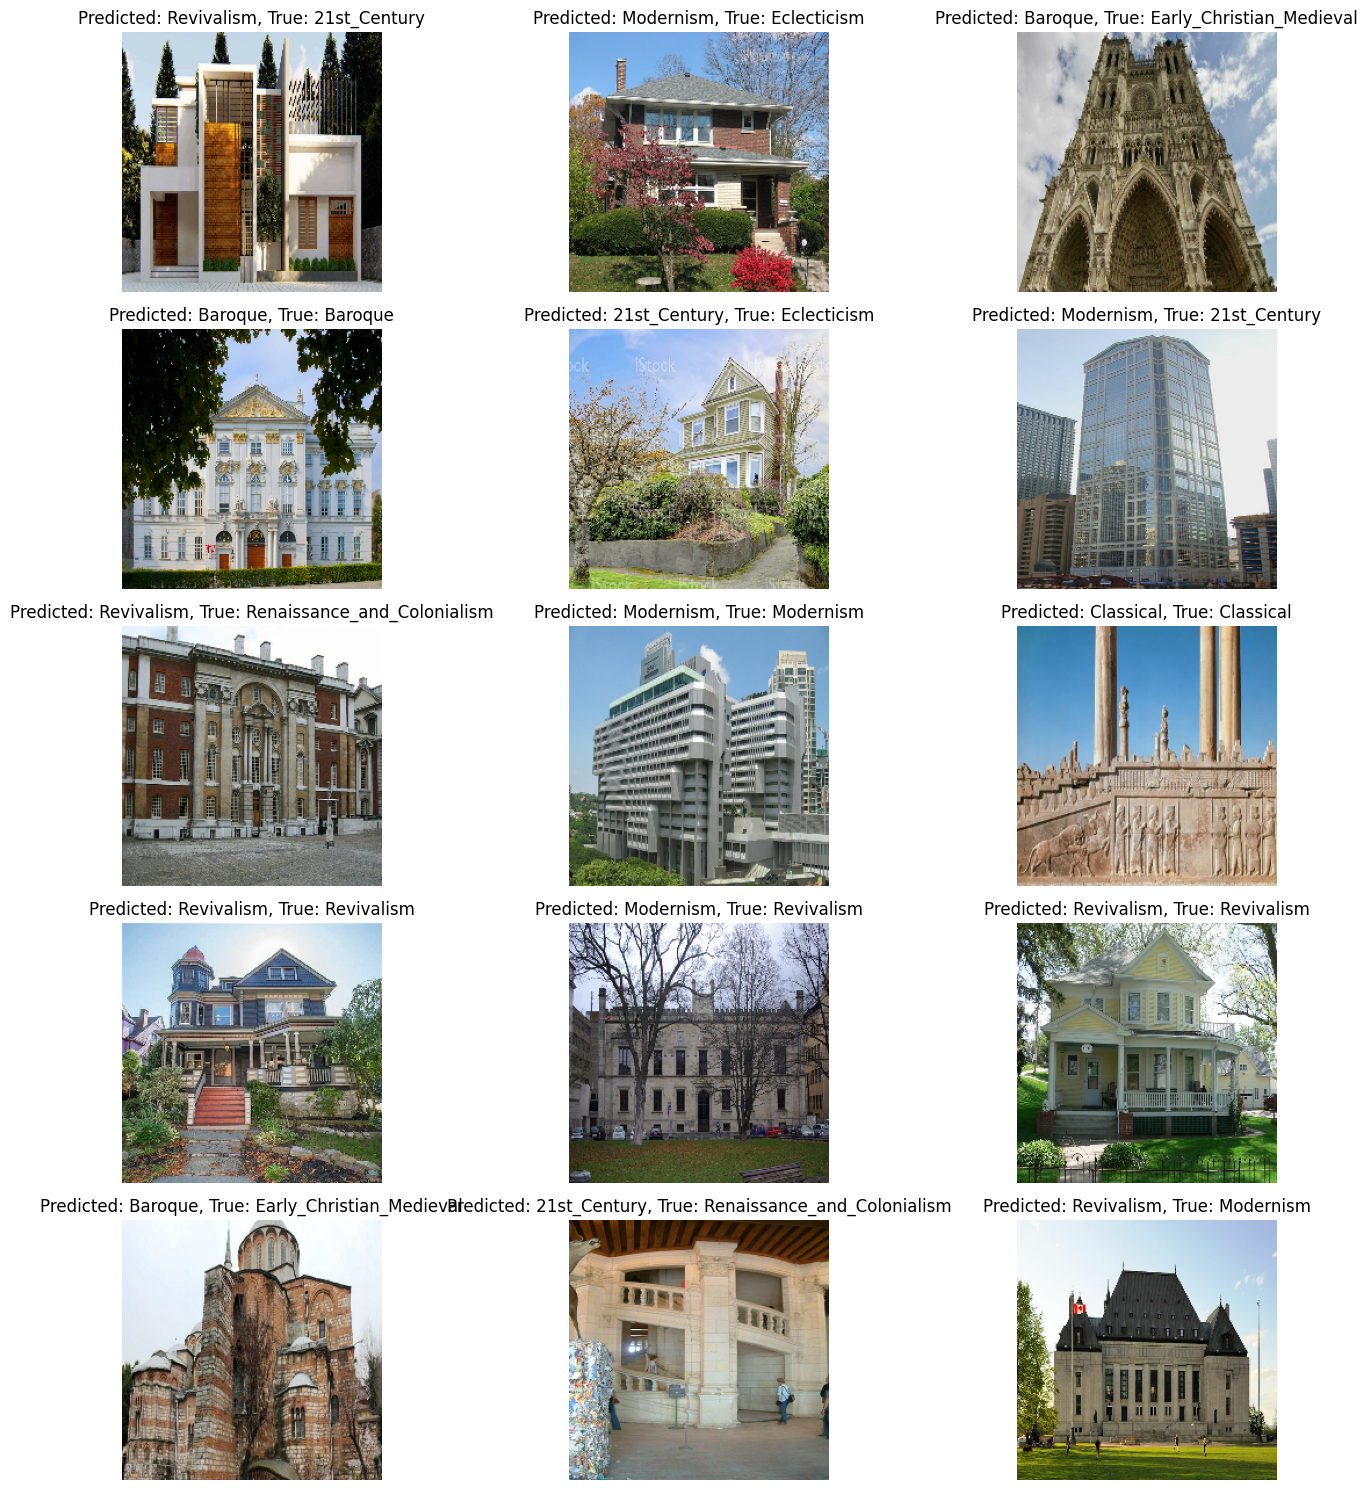

In [23]:
# Function to display images with their predicted labels
def display_predicted_images(model, dataset, class_names, num_images):
    plt.figure(figsize=(15, 15))
    for images, labels in dataset.take(1):
        predictions = model.predict(images)
        for i in range(num_images):
            ax = plt.subplot(5, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            predicted_label = tf.argmax(predictions[i])
            true_label = labels[i].numpy()
            plt.title(f'Predicted: {class_names[predicted_label]}, True: {class_names[true_label]}')
            plt.axis("off")
    plt.tight_layout()
    plt.show()

# Display 25 images from the test dataset with their predicted labels
display_predicted_images(model, test_ds, class_names, 15)